In [25]:
!pip install -Uqq fastai

Download images of cows and non-cows

In [26]:
!pip install -Uqq duckduckgo_search

In [27]:
from duckduckgo_search import ddg_images
from fastcore.all import*

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [28]:
urls = search_images('cow photos', max_images=1)
urls[0]

'https://wallsdesk.com/wp-content/uploads/2017/01/Cow-Images.jpg'

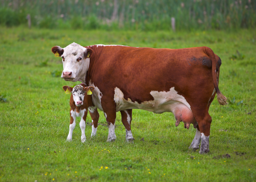

In [29]:
from fastdownload import download_url
dest = 'cow.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import*
im = Image.open(dest)
im.to_thumb(256,256)

Download photos of goats

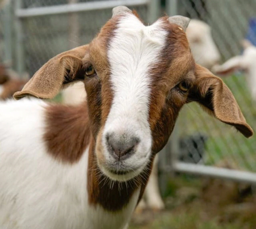

In [30]:
download_url(search_images('goat photos', max_images=1)[0], 'goat.jpg', show_progress=False)
Image.open('goat.jpg').to_thumb(256.256)


In [31]:
searches = 'cow','goat'
path = Path('cow_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Train the model

In [32]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

5

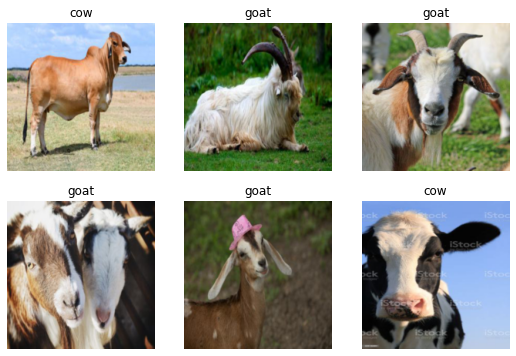

In [33]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)
dls.show_batch(max_n=6)

In [34]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/srv/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/srv/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.805756,0.536529,0.150655,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.407732,0.379282,0.115721,00:05
1,0.298365,0.296070,0.093886,00:05
2,0.204132,0.300080,0.113537,00:05


In [35]:
is_cow,_,probs = learn.predict(PILImage.create('cow.jpg'))
print(f"This is a:{is_cow}.")
print(f"Probabilty it's a cow:{probs[0]:.4f}")


This is a:cow.
Probabilty it's a cow:0.9999
